In [20]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Input, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras import backend as K
from multiprocessing import Pool
import sklearn
import argparse
import subprocess
import os
from PIL import Image
import time
import matplotlib.pyplot as plt



import time
from keras.preprocessing import image, sequence
from keras import backend as K


LABELS = 228

layer_name = 'conv1'



def create_model(base_net):
    """
    In here you can define your model
    NOTE: Since we are only saving the model weights, you cannot load model weights that do
    not have the exact same architecture.
    :return:
    """
    # model = Sequential()
    # model.add(Dense(42, activation='relu'))
    # model.add((Dense(6, activation='sigmoid')))
    
    
    if base_net == 'vgg': 
        x = VGG16(weights='imagenet', include_top=False)
    elif base_net == 'resnet':
        x = ResNet50(weights='imagenet', include_top=False)
        
    for layer in x.layers[1:]:
        layer.trainable = False

    input = Input(shape=(256,256,3), name='image_input')
    x = x(input)

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(LABELS, activation='sigmoid', name='predictions')(x)

    model = Model(input=input, output=x)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x



def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())



model = create_model('resnet')
model.load_weights('resnet.h5', by_name=True)

#--------------------------- visualization begins

img_width = 256
img_height = 256

# this is the placeholder for the input images
input_img = model.input


res = model.layers[1]
layer_dict = dict([(layer.name, layer) for layer in res.layers[1:]])



c:\users\ruben\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              8392704   
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 228)               934116    
Total params: 49,695,844
Trainable params: 26,108,132
Non-trainable params: 23,587,712
_______________________________________________________

Testing stuff

In [21]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from vis.visualization import get_num_filters
from vis.input_modifiers import Jitter



In [5]:
dict([(layer.name, layer) for layer in model.layers[1:]])


{'fc1': <keras.layers.core.Dense at 0x20a6fe7fa90>,
 'fc2': <keras.layers.core.Dense at 0x20a68d98240>,
 'flatten': <keras.layers.core.Flatten at 0x20a68dd9048>,
 'predictions': <keras.layers.core.Dense at 0x20a01489eb8>,
 'resnet50': <keras.engine.training.Model at 0x20a68c6d080>}

In [6]:
layer_idx = utils.find_layer_idx(model, 'predictions')

In [22]:
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
#model.layers[1].layers[layer_idx].activation = activations.linear

model = utils.apply_modifications(model)

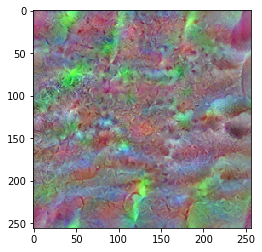

In [13]:
filter_idx = 120
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_modifiers=[Jitter(16)])
#img = visualize_activation(model.layers[1], layer_idx, filter_indices=filter_idx)
plt.imsave('predictions-'+ str(filter_idx) + '-label-out-jitter.png', img)
plt.imshow(img)

# Convolutional

Try convolutional layers:


In [25]:
dict([(layer.name, layer) for layer in model.layers[1].layers[1:]])


{'activation_50': <keras.layers.core.Activation at 0x20a41134908>,
 'activation_51': <keras.layers.core.Activation at 0x20a41134eb8>,
 'activation_52': <keras.layers.core.Activation at 0x20a4113f6a0>,
 'activation_53': <keras.layers.core.Activation at 0x20a4113fc18>,
 'activation_54': <keras.layers.core.Activation at 0x20a4113fef0>,
 'activation_55': <keras.layers.core.Activation at 0x20a487db1d0>,
 'activation_56': <keras.layers.core.Activation at 0x20a487db4e0>,
 'activation_57': <keras.layers.core.Activation at 0x20a487db7b8>,
 'activation_58': <keras.layers.core.Activation at 0x20a487dba90>,
 'activation_59': <keras.layers.core.Activation at 0x20a487dbda0>,
 'activation_60': <keras.layers.core.Activation at 0x20a4113ff98>,
 'activation_61': <keras.layers.core.Activation at 0x20a487c6390>,
 'activation_62': <keras.layers.core.Activation at 0x20a487c6940>,
 'activation_63': <keras.layers.core.Activation at 0x20a487c6c18>,
 'activation_64': <keras.layers.core.Activation at 0x20a487c6e

In [26]:
layer_name = 'res3b_branch2b'
layer_idx = utils.find_layer_idx(model.layers[1], layer_name)

In [27]:
filters = np.arange(get_num_filters(model.layers[1].layers[layer_idx]))

In [28]:
# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model.layers[1], layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

AttributeError: Layer resnet50 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.